In [1]:
import importlib
import utils
importlib.reload(utils)
from utils import extract_pool,model_grps_config
import utils.optim_utils
importlib.reload(utils.optim_utils)
from utils.optim_utils import optim, optim_pool, pt_create_corr_rdm_short
from utils.data_utils import load_obj, SAVE_DIR, UD_PARENT, RESULTS_DIR, LEX_PATH_SET, save_obj, ANALYZE_DIR
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm 
from tqdm import tqdm
import tsnecuda
import seaborn as sns 
import pandas as pd 
import os 
from sklearn.model_selection import LeaveOneOut
from tqdm import tqdm
import tqdm.notebook as tq
from tqdm import tqdm_notebook
import fnmatch 
import re
from mpl_toolkits.axes_grid1 import make_axes_locatable

Loading lookup from /om/user/ehoseini/miniconda3/lib/python3.7/site-packages/brainio_collection/lookup.csv


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/brainscore/metrics/__init__.py:37: FutureWarning: xarray subclass Score should explicitly define __slots__
  class Score(DataAssembly):


In [3]:
#extract_id=['group=gpt2-xl_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=ctrl_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=bert-large-uncased-whole-word-masking_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=albert-xxlarge-v2_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=roberta-base_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=xlm-mlm-en-2048_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False',
#            'group=xlnet-large-cased_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False']

extract_id=['group=gpt2-xl_layer_compare_v1-dataset=coca_spok_filter_punct_10K_sample_2-activation-bench=None-ave=False']


optim_id=['coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=50-n_init=2-run_gpu=True',
          'coordinate_ascent_eh-obj=D_s_var-n_iter=1000-n_samples=50-n_init=2-run_gpu=True']

In [4]:
optim_files=[]
optim_results=[]
for ext in extract_id:
    for optim in optim_id:
        optim_file=os.path.join(RESULTS_DIR,f"results_{ext}_{optim}.pkl")
        optim_files.append(optim_file)
        optim_results.append(load_obj(optim_file))

loading /om/user/ehoseini/MyData/sent_sampling/results/results_group=gpt2-xl_layer_compare_v1-dataset=coca_spok_filter_punct_10K_sample_2-activation-bench=None-ave=False_coordinate_ascent_eh-obj=D_s-n_iter=1000-n_samples=50-n_init=2-run_gpu=True.pkl
loading /om/user/ehoseini/MyData/sent_sampling/results/results_group=gpt2-xl_layer_compare_v1-dataset=coca_spok_filter_punct_10K_sample_2-activation-bench=None-ave=False_coordinate_ascent_eh-obj=D_s_var-n_iter=1000-n_samples=50-n_init=2-run_gpu=True.pkl


1.00576
1.00422


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "frameon" which is no longer supported as of 3.3 and will become an error two minor releases later


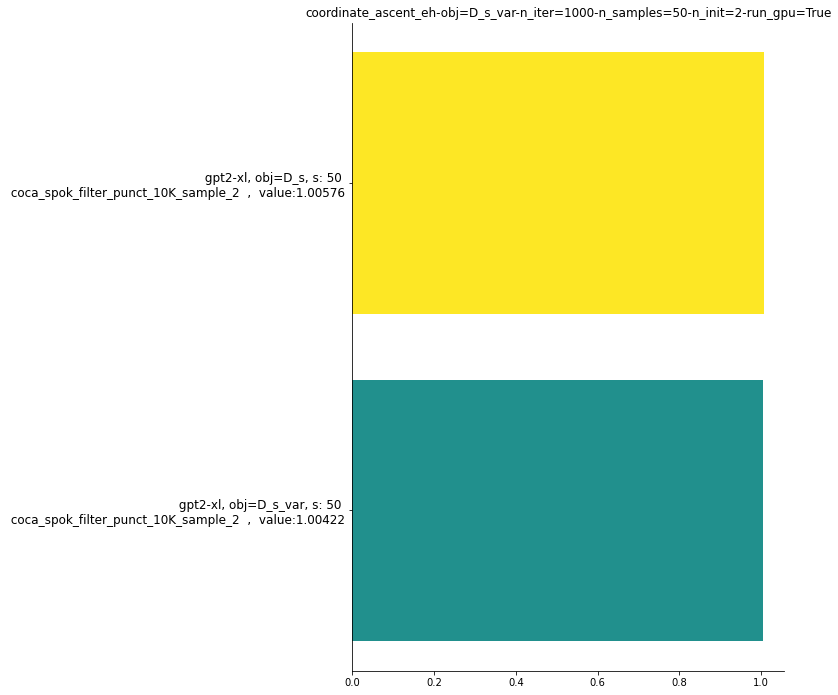

In [5]:
fig = plt.figure(figsize=[15,15])
ax = fig.add_axes([.1,.1,.4,.6])

cmap=cm.get_cmap('viridis_r')

alph_col=cmap(np.divide(range(len(optim_results)),len(optim_results)))
tick_l=[]
tick=[]
for idx, res in enumerate(optim_results):
    ax.barh(idx,res['optimized_d'],color=alph_col[[idx],:],label=res['optimizatin_name'])
    ext_obj=extract_pool[res['extractor_name']]()
    str_val="{:.5f}".format(res['optimized_d'])
    print(f"{str_val}")
    optim_type=re.search('obj=\w+-',res['optimizatin_name'])[0][0:-1]
    tick_l.append(f" {np.unique(ext_obj.model_spec)[0]}, {optim_type}, s: {len(res['optimized_S'])} \n {ext_obj.dataset}  ,  value:{str_val}")
    tick.append(idx)


#ax.set_xlabel(f"D_s \n\n  models:{ext_obj.model_spec}\nlayers:{ext_obj.layer_spec} averaging : {ext_obj.average_sentence}",fontsize=12)
ax.set_yticklabels(tick_l,fontsize=12)
ax.set_yticks(tick)
ax.set_title(res['optimizatin_name'],fontsize=12)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
#ax.legend(bbox_to _anchor=(1.1, .85), frameon=True,fontsize=12)
ax.invert_yaxis()
#fig.savefig(os.path.join(Analysis_path,'DV_test_gamma_alpha_is_0.pdf'))
plt.savefig(os.path.join(ANALYZE_DIR,f"U01_SET2_optimization_results.png"), dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)  


In [ ]:
ig = plt.figure(figsize=[15,15])
ax = fig.add_axes([.1,.1,.4,.6])

cmap=cm.get_cmap('viridis_r')

alph_col=cmap(np.divide(range(len(optim_results)),len(optim_results)))
tick_l=[]
tick=[]
for idx, res in enumerate(optim_results):
    
    #ax.barh(idx,res['optimized_d'],color=alph_col[[idx],:],label=res['optimizatin_name'])
    ext_obj=extract_pool[res['extractor_name']]()
    ext_obj.load_dataset()
    optimizer_obj = optim_pool[res['optimizatin_name']]()
    optimizer_obj.load_extractor(ext_obj)
    optimizer_obj.precompute_corr_rdm_on_gpu()
    str_val="{:.5f}".format(res['optimized_d'])
    print(f"{str_val}")
    optim_type=re.search('obj=\w+-',res['optimizatin_name'])[0][0:-1]
    tick_l.append(f" {np.unique(ext_obj.model_spec)[0]}, {optim_type}, s: {len(res['optimized_S'])} \n {ext_obj.dataset}  ,  value:{str_val}")
    tick.append(idx)

In [11]:
ext_obj.load_dataset()
ext_obj()
optimizer_obj = optim_pool[res['optimizatin_name']]()
optimizer_obj.load_extractor(ext_obj)

optimizer_obj.precompute_corr_rdm_on_gpu()
    

1111it [00:00, 210720.44it/s]
1111it [00:00, 209281.94it/s]
1111it [00:00, 209084.75it/s]
1111it [00:00, 198630.51it/s]
0it [00:00, ?it/s]

loading /om/user/ehoseini/MyData/COCA_corpus/parsed/coca_spok_data_filter_ngram_punct_10K_sample_2.pkl


1111it [00:00, 202814.75it/s]
1111it [00:00, 199643.19it/s]
1111it [00:00, 180433.35it/s]
1111it [00:00, 168008.07it/s]
1112it [00:00, 204734.91it/s]


extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_26_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_26_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_33_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_33_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_44_activatio

In [6]:
num_iter=100
num_samples=50

for idx, res in enumerate(optim_results):
    if idx>0:
        ext_obj=extract_pool[res['extractor_name']]()
        mdl_name=np.unique(ext_obj.model_spec)[0]
        group=f'{mdl_name}_layers'
        extractor_id=f'group={group}-dataset={ext_obj.dataset}-{ext_obj.extract_type}-bench=None-ave={ext_obj.average_sentence}'
        extractor_obj = extract_pool[extractor_id]()
        extractor_obj.load_dataset()
        model_layers = extractor_obj.layer_name
        extractor_obj()
        mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())
        optim_obj=optim_pool[res['optimizatin_name']]()
        optim_obj.load_extractor(extractor_obj)
        layer_id_list=[x['layer'] for x in optim_obj.activations]
        del extractor_obj
        activation_list=[]
        var_explained=[]
        loadings=[]
        components=[]
        pca_type='fixed'
        for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
            act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
    # act must be in m sample * n feature shape ,
            u,s,v=torch.pca_lowrank(act,q=200)
    # keep 85% variance explained ,
            idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
            cols=list(torch.where(idx_85)[0].cpu().numpy())
            if pca_type=='fixed':
                act_pca = torch.matmul(act, v[:, :100])
            elif pca_type=='equal_var':
                act_pca = torch.matmul(act, v[:, cols])
        
            activation_list.append(act_pca)
            var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
    #var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))
        var_explained=torch.stack(var_explained).cpu()
  
        total_sent=activation_list[0].shape[0]
        act_list_norm=[(X-X.mean(axis=1,keepdim=True)) for X in activation_list]
        act_list_norm=[torch.nn.functional.normalize(X) for X in act_list_norm]
        layer_dist=[]
        for idx in tqdm_notebook(range(len(activation_list))):
            pair_dist=[]
            for idy in tqdm_notebook(range(len(activation_list)),position=1):
                sample_dist=[]
                pair_list_norm=[act_list_norm[idx],act_list_norm[idy]]
                XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in
                            pair_list_norm]
                for sample_iter in range(num_iter):
                    samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
                    pairs = torch.combinations(samples, with_replacement=False)
                    XY_corr_sample = [XY_corr[pairs[:, 0], pairs[:, 1]] for XY_corr in XY_corr_list]
                    XY_corr_sample_tensor = torch.stack(XY_corr_sample)
                    XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
                    if XY_corr_sample_tensor.shape[1] < XY_corr_sample_tensor.shape[0]:
                        XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
                    assert (XY_corr_sample_tensor.shape[1] > XY_corr_sample_tensor.shape[0])
                    d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=samples.device)
                #n1 = d_mat.shape[1],
                #correction = n1 * n1 / (n1 * (n1 - 1) / 2),
                #d_val = correction * d_mat.mean(dim=(0, 1)),
                    d_val = d_mat[0,1]
                    sample_dist.append(d_val)
                pair_dist.append(torch.stack(sample_dist))
            layer_dist.append(pair_dist)
            
        optim_act_list_norm=[x[res['optimized_S'],:] for x in act_list_norm]
        layer_similarity=[pt_create_corr_rdm_short(x) for x in optim_act_list_norm]
        optim_pairs = torch.combinations(torch.tensor(np.arange(len(res['optimized_S']))), with_replacement=False)
        layer_optim_dist=[]
        for idx in tqdm_notebook(range(len(activation_list))):
            pair_optim_dist=[]
            for idy in tqdm_notebook(range(len(activation_list)),position=1):
                pair_similarity=[layer_similarity[idx],layer_similarity[idy]]
                XY_corr_sample = [XY_corr[optim_pairs[:, 0], optim_pairs[:, 1]] for XY_corr in pair_similarity]
                XY_corr_sample_tensor=torch.stack(XY_corr_sample)
                d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=XY_corr_sample_tensor.device)
                d_val =d_mat[0,1].cpu()
                pair_optim_dist.append([d_val])
            layer_optim_dist.append(pair_optim_dist)
        print("Done!")
        pereira_settings=extract_pool['group=best_performing_pereira_1-dataset=ud_sentences-activation-bench=None-ave=False']()

        try :
            model_loc = pereira_settings.model_spec.index(mdl_name)
            pereira_layer_id=pereira_settings.layer_spec[model_loc]
        except ValueError as e:
            pereira_layer_id=np.argmax(score_score)
        
        
        Pereira_dist=torch.mean(torch.stack(layer_dist[pereira_layer_id]),dim=1)
        dist_val,dist_idx=torch.sort(Pereira_dist)
        assert(dist_idx[0]==pereira_layer_id)
        cuts=np.linspace(dist_val.cpu().numpy().min(),dist_val.cpu().numpy().max(),4,endpoint=False)
        Pereira_dist_optim=torch.tensor([torch.stack([x[0] for x in y]) for y in layer_optim_dist][pereira_layer_id])
        dist_val_optim,dist_idx_optim=torch.sort(Pereira_dist_optim)
        Pereira_ordered=Pereira_dist_optim[dist_idx]
        assert(dist_idx[0]==pereira_layer_id)

        fig = plt.figure(figsize=(8,8*1.5))

        ax = fig.add_axes((.1,.4,.3*1.5,.3))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=.05, pad=0.1)
        im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),aspect='auto',interpolation='none')
        ax.set_yticks(np.arange(var_explained.shape[0]))
        ax.set_xticks(np.arange(var_explained.shape[0]))
        ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ])
        ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90)

        cbar = fig.colorbar(im, cax=cax)


        ax = fig.add_axes((.65,.4,.3*1.5,.3))
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size=.05, pad=0.1)
        im = ax.imshow(torch.stack([torch.stack([x[0] for x in y]) for y in layer_optim_dist]).cpu(),aspect='auto',interpolation='none')
        ax.set_yticks(np.arange(var_explained.shape[0]))
        ax.set_xticks(np.arange(var_explained.shape[0]))
        ax.set_yticklabels([ ])
        ax.set_xticklabels([ ],rotation=90)

        cbar = fig.colorbar(im, cax=cax)
        ax = fig.add_axes((.2,.1,.8,.12))
        ax.scatter(np.arange(dist_val.cpu().shape[0]),dist_val.cpu(),zorder=3)
        ax.scatter(np.arange(dist_val_optim.cpu().shape[0]),Pereira_ordered.cpu(),zorder=4)

        ax.set_xlim((-1,dist_val_optim.cpu().shape[0]+1))
        ax.set_ylim((0-.05,np.max(dist_val_optim.cpu().numpy())+.05))
        #[ax.plot(plt.xlim(),[x,x],'k--') for x in cuts],
        #closest_points=[np.argmin(np.abs(dist_val.cpu()-x)) for x in cuts],
        #optimized_dist=torch.tensor([dist_val_optim[dist_idx_optim==x] for x in extractor_obj.layer_spec]),
        #optimized_dist_loc=torch.tensor([torch.where(dist_idx_optim==x) for x in extractor_obj.layer_spec]),
        #ax.scatter(optimized_dist_loc.cpu(),optimized_dist.cpu(),50,color=(0,0,0)),
        closest_points=[int(np.where(dist_idx.cpu().numpy()==x)[0]) for x in res['layer_spec']]
        [ax.scatter(x,dist_val[x].cpu().numpy(),50,color=(0,0,0),zorder=5) for x in closest_points]
        [ax.scatter(x,Pereira_ordered[x].cpu().numpy(),50,color=(1,0,0),zorder=5) for x in closest_points]

        ax.set_xticks(tuple(np.arange(dist_val.cpu().shape[0])))
        ax.set_xticklabels(dist_idx.cpu().numpy())
        ax.set_xticklabels([model_layers[int(x)] for x in dist_idx.cpu().numpy()],rotation=90)
        [ax.plot([x,x],plt.ylim(),'k-',zorder=2) for x in closest_points]
        
        ax.set_title( f"{res['extractor_name']} , \n {res['optimizatin_name']}",fontsize=12)
        
        plt.savefig(os.path.join(ANALYZE_DIR,f"{res['extractor_name']}_{res['optimizatin_name']}_RDM.png"), dpi=None, facecolor='w', edgecolor='w',
       orientation='portrait',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)  

loading /om/user/ehoseini/MyData/COCA_corpus/parsed/coca_spok_data_filter_ngram_punct_10K_sample_2.pkl


1111it [00:00, 222971.04it/s]
1111it [00:00, 224799.64it/s]
1111it [00:00, 226846.06it/s]
1111it [00:00, 211523.91it/s]
1111it [00:00, 211850.87it/s]
1111it [00:00, 211274.56it/s]
1111it [00:00, 217446.18it/s]
1111it [00:00, 176670.90it/s]
1112it [00:00, 178761.49it/s]


extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_0_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_0_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_1_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_1_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_2_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_2_activation_ave_False.pkl
adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_3_activation_ave

0it [00:00, ?it/s]

adding activations to set
extracting network activations for gpt2-xl
coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_48_activation_ave_False.pkl already exists, loading...
loading /om/user/ehoseini/MyData/sent_sampling/coca_spok_filter_punct_10K_sample_2_gpt2-xl_layer_48_activation_ave_False.pkl
adding activations to set


49it [02:03,  2.51s/it]
/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/49 [00:00<?, ?it/s]

/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [11]:
f"{res['extractor_name']}_{res['optimizatin_name']}_RDM.png"

'group=xlnet-large-cased_layer_compare_v1-dataset=ud_sentencez_token_filter_v3-activation-bench=None-ave=False_coordinate_ascent_eh-obj=D_s_var-n_iter=1000-n_samples=50-n_init=2-run_gpu=True_RDM.png'

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(10,15))
ax = fig.add_axes((.1,.4,.5*1.5,.5))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.1, pad=0.5)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
#ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ])
#ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90)


ax = fig.add_axes((.1,.1,.5*1.37,.18))
ax.set_title(f"{res['extractor_name']}_num_samples_{num_samples}_num_iter_{num_iter}")
ax.scatter(np.arange(dist_val.cpu().shape[0]),dist_val.cpu())
ax.set_xlim((-1,dist_val.cpu().shape[0]+1))
ax.set_ylim((0-.05,np.max(dist_val.cpu().numpy())+.05))
[ax.plot(plt.xlim(),[x,x],'k--') for x in cuts],
closest_points=[np.argmin(np.abs(dist_val.cpu()-x)) for x in cuts]
[ax.scatter(x.cpu().numpy(),dist_val[int(x.cpu().numpy())].cpu().numpy(),60,color=(0,0,0)) for x in closest_points]
ax.set_xticks(tuple(np.arange(dist_val.cpu().shape[0])))
    #ax.set_xticklabels(dist_idx.cpu().numpy()),
ax.set_xticklabels([model_layers[int(x)] for x in dist_idx.cpu().numpy()],rotation=90)
[ax.plot([x.cpu().numpy(),x.cpu().numpy()],plt.ylim(),'k-') for x in closest_points]
ax.set_xlim((0-.5,len(dist_idx)-.5))
#plt.savefig(os.path.join(ANALYZE_DIR,f"{extractor_id}_num_samples_{num_samples}_num_iter_{num_iter}_layerwise_similiarty_dist_vs_score.png"), dpi=None, facecolor='w', edgecolor='w',
#       orientation='portrait',transparent=True, bbox_inches=None, pad_inches=0.1,frameon=False)  

In [ ]:
ext_obj=extract_pool[res['extractor_name']]()
mdl_name=np.unique(ext_obj.model_spec)[0]
group=f'{mdl_name}_layers'
extractor_id=f'group={group}-dataset={ext_obj.dataset}-{ext_obj.extract_type}-bench=None-ave={ext_obj.average_sentence}'
extractor_obj = extract_pool[extractor_id]()
extractor_obj.load_dataset()
model_layers = extractor_obj.layer_name
extractor_obj()
mdl_name=str(np.unique(extractor_obj.model_spec).squeeze())
optim_obj=optim_pool[res['optimizatin_name']]()
optim_obj.load_extractor(extractor_obj)

In [12]:
layer_id_list=[x['layer'] for x in optim_obj.activations]
del extractor_obj
activation_list=[]
var_explained=[]
loadings=[]
components=[]
pca_type='fixed'
for idx, act_dict in tqdm(enumerate(optim_obj.activations)):
    act=torch.tensor(act_dict['activations'], dtype=float, device=optim_obj.device, requires_grad=False)
# act must be in m sample * n feature shape ,
    u,s,v=torch.pca_lowrank(act,q=200)
# keep 85% variance explained ,
    idx_85=torch.cumsum(s**2,dim=0)/torch.sum(s**2)<.85
    cols=list(torch.where(idx_85)[0].cpu().numpy())
    if pca_type=='fixed':
        act_pca = torch.matmul(act, v[:, :100])
    elif pca_type=='equal_var':
        act_pca = torch.matmul(act, v[:, cols])

    activation_list.append(act_pca)
    var_explained.append(torch.cumsum(torch.cat((torch.tensor([0],device=optim_obj.device),s**2)),dim=0)/torch.sum(s**2))
#var_explained.append(torch.cumsum(s**2,dim=0)/torch.sum(s**2))



25it [00:36,  1.45s/it]


In [ ]:
var_explained=torch.stack(var_explained).cpu()

total_sent=activation_list[0].shape[0]
act_list_norm=[(X-X.mean(axis=1,keepdim=True)) for X in activation_list]
act_list_norm=[torch.nn.functional.normalize(X) for X in act_list_norm]
layer_dist=[]
for idx in tqdm_notebook(range(len(activation_list))):
    pair_dist=[]
    for idy in tqdm_notebook(range(len(activation_list)),position=1):
        sample_dist=[]
        pair_list_norm=[act_list_norm[idx],act_list_norm[idy]]
        XY_corr_list = [torch.tensor(1, device=X.device, dtype=float) - torch.mm(X, torch.transpose(X, 1, 0)) for X in
                    pair_list_norm]
        for sample_iter in range(num_iter):
            samples=torch.tensor(np.random.choice(total_sent,num_samples,replace=False), dtype = torch.long, device = act_list_norm[0].device)
            pairs = torch.combinations(samples, with_replacement=False)
            XY_corr_sample = [XY_corr[pairs[:, 0], pairs[:, 1]] for XY_corr in XY_corr_list]
            XY_corr_sample_tensor = torch.stack(XY_corr_sample)
            XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
            if XY_corr_sample_tensor.shape[1] < XY_corr_sample_tensor.shape[0]:
                XY_corr_sample_tensor = torch.transpose(XY_corr_sample_tensor, 1, 0)
            assert (XY_corr_sample_tensor.shape[1] > XY_corr_sample_tensor.shape[0])
            d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=samples.device)
        #n1 = d_mat.shape[1],
        #correction = n1 * n1 / (n1 * (n1 - 1) / 2),
        #d_val = correction * d_mat.mean(dim=(0, 1)),
            d_val = d_mat[0,1]
            sample_dist.append(d_val)
        pair_dist.append(torch.stack(sample_dist))
    layer_dist.append(pair_dist)


In [ ]:
optim_act_list_norm=[x[res['optimized_S'],:] for x in act_list_norm]
layer_similarity=[pt_create_corr_rdm_short(x) for x in optim_act_list_norm]
optim_pairs = torch.combinations(torch.tensor(np.arange(len(res['optimized_S']))), with_replacement=False)
layer_optim_dist=[]
for idx in tqdm_notebook(range(len(activation_list))):
    pair_optim_dist=[]
    for idy in tqdm_notebook(range(len(activation_list)),position=1):
        pair_similarity=[layer_similarity[idx],layer_similarity[idy]]
        XY_corr_sample = [XY_corr[optim_pairs[:, 0], optim_pairs[:, 1]] for XY_corr in pair_similarity]
        XY_corr_sample_tensor=torch.stack(XY_corr_sample)
        d_mat = pt_create_corr_rdm_short(XY_corr_sample_tensor, device=XY_corr_sample_tensor.device)
        d_val =d_mat[0,1].cpu()
        pair_optim_dist.append([d_val])
    layer_optim_dist.append(pair_optim_dist)
print("Done!")
pereira_settings=extract_pool['group=best_performing_pereira_1-dataset=ud_sentences-activation-bench=None-ave=False']()

try :
    model_loc = pereira_settings.model_spec.index(mdl_name)
    pereira_layer_id=pereira_settings.layer_spec[model_loc]
except ValueError as e:
    pereira_layer_id=np.argmax(score_score)


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


/om/user/ehoseini/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """


[[<matplotlib.lines.Line2D at 0x2aad30475690>],

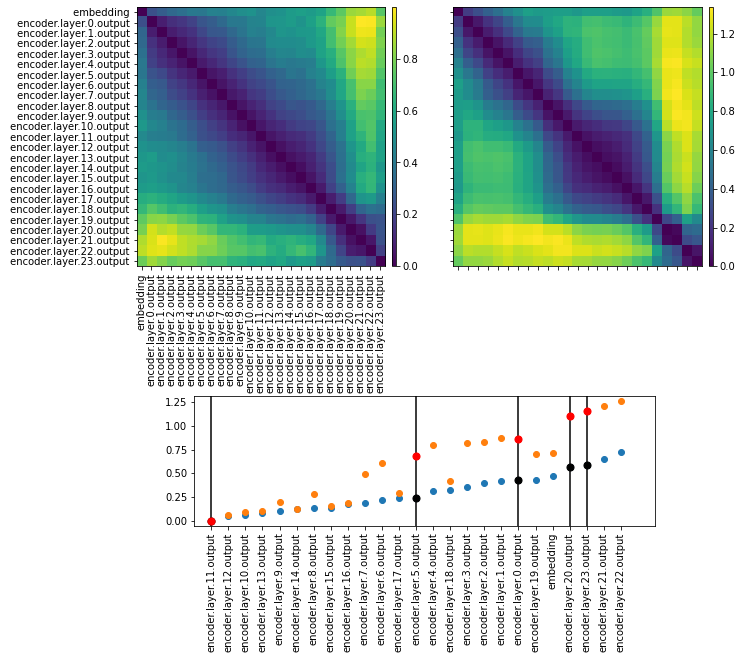

In [48]:
Pereira_dist=torch.mean(torch.stack(layer_dist[pereira_layer_id]),dim=1)
dist_val,dist_idx=torch.sort(Pereira_dist)
assert(dist_idx[0]==pereira_layer_id)
cuts=np.linspace(dist_val.cpu().numpy().min(),dist_val.cpu().numpy().max(),4,endpoint=False)
Pereira_dist_optim=torch.tensor([torch.stack([x[0] for x in y]) for y in layer_optim_dist][pereira_layer_id])
dist_val_optim,dist_idx_optim=torch.sort(Pereira_dist_optim)
Pereira_ordered=Pereira_dist_optim[dist_idx]
assert(dist_idx[0]==pereira_layer_id)

fig = plt.figure(figsize=(8,8*1.5))

ax = fig.add_axes((.1,.4,.3*1.5,.3))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.05, pad=0.1)
im = ax.imshow(torch.stack([torch.stack([x.mean() for x in y]) for y in layer_dist]).cpu(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([f" {model_layers[idx]}" for idx,x in enumerate(var_explained) ])
ax.set_xticklabels([f"{model_layers[idx]}" for idx,x in enumerate(var_explained) ],rotation=90)

cbar = fig.colorbar(im, cax=cax)


ax = fig.add_axes((.65,.4,.3*1.5,.3))
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size=.05, pad=0.1)
im = ax.imshow(torch.stack([torch.stack([x[0] for x in y]) for y in layer_optim_dist]).cpu(),aspect='auto',interpolation='none')
ax.set_yticks(np.arange(var_explained.shape[0]))
ax.set_xticks(np.arange(var_explained.shape[0]))
ax.set_yticklabels([ ])
ax.set_xticklabels([ ],rotation=90)

cbar = fig.colorbar(im, cax=cax)





ax = fig.add_axes((.2,.1,.8,.15))
ax.scatter(np.arange(dist_val.cpu().shape[0]),dist_val.cpu(),zorder=3)
ax.scatter(np.arange(dist_val_optim.cpu().shape[0]),Pereira_ordered.cpu(),zorder=4)

ax.set_xlim((-1,dist_val_optim.cpu().shape[0]+1))
ax.set_ylim((0-.05,np.max(dist_val_optim.cpu().numpy())+.05))
#[ax.plot(plt.xlim(),[x,x],'k--') for x in cuts],
#closest_points=[np.argmin(np.abs(dist_val.cpu()-x)) for x in cuts],
#optimized_dist=torch.tensor([dist_val_optim[dist_idx_optim==x] for x in extractor_obj.layer_spec]),
#optimized_dist_loc=torch.tensor([torch.where(dist_idx_optim==x) for x in extractor_obj.layer_spec]),
#ax.scatter(optimized_dist_loc.cpu(),optimized_dist.cpu(),50,color=(0,0,0)),
closest_points=[int(np.where(dist_idx.cpu().numpy()==x)[0]) for x in res['layer_spec']]
[ax.scatter(x,dist_val[x].cpu().numpy(),50,color=(0,0,0),zorder=5) for x in closest_points]
[ax.scatter(x,Pereira_ordered[x].cpu().numpy(),50,color=(1,0,0),zorder=5) for x in closest_points]

ax.set_xticks(tuple(np.arange(dist_val.cpu().shape[0])))
ax.set_xticklabels(dist_idx.cpu().numpy())
ax.set_xticklabels([model_layers[int(x)] for x in dist_idx.cpu().numpy()],rotation=90)
[ax.plot([x,x],plt.ylim(),'k-',zorder=2) for x in closest_points]

